In [1]:
## -*- coding: utf-8 -*- 

import numpy as np
import pandas as pd

from pathlib import Path

from hbayesdm.models import ra_prospect

import nibabel as nib

from bids import BIDSLayout
from tqdm import tqdm

from sklearn.linear_model import ElasticNet, LinearRegression

from scipy.stats import zscore

import matplotlib.pyplot as plt

import nilearn as nil
from nilearn.image import resample_to_img, load_img, smooth_img
from nilearn.datasets import load_mni152_template, load_mni152_brain_mask
from nilearn.input_data import NiftiMasker
from nilearn.plotting import plot_stat_map, show

from nipy.modalities.fmri import hemodynamic_models
from nipy.modalities.fmri.hemodynamic_models import compute_regressor

import pickle

In [2]:
template = load_mni152_template()
mask = load_mni152_brain_mask()

In [3]:
# information for path, hyperparams..
data_dir = '/home/mybirth0407/datasets/ds000005' # custom directory

In [4]:
layout = BIDSLayout(data_dir, derivatives=True)

# if data_dir not include derivatives files
# layout.add_derivatives(DERIVATIVES_PATH)

/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/bids/layout/models.py:102: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)


# Single subject, multiple run

In [7]:
subject_id = layout.get_subject()[0]

In [8]:
image_samples = layout.derivatives['fMRIPrep'].get(
    subject=subject_id,
    return_type='file',
    suffix='smoothed',
    extension='nii.gz')

event_samples = layout.get(
    subject=subject_id,
    return_type='file',
    suffix='events',
    extension='tsv')

In [10]:
fmri_info = {
    't': nib.load(image_samples[0]).shape[-1],
    'tr': layout.get_tr()
}

In [32]:
# df_events = []

# for i, event_sample in enumerate(event_samples):
#     df = pd.read_table(event_sample)
#     df['subjID'] = subject_id
#     df['run'] = i + 1
#     df_events.append(df)
# df_events = pd.concat(df_events)

# df_events['respcat'] = df_events['respcat'].apply(lambda x: 1 if x == 1 else 0)
# df_events['onset'] = df_events['onset'].astype(np.int)
# df_events['cert'] = 0 # certain..?
# df_events['gamble'] = df_events['respcat']

# columns = df_events.columns.copy() # for safety
# df_events.head()

,onset,duration,parametric loss,distance from indifference,parametric gain,gain,loss,PTval,respnum,respcat,response_time,subjID,run,cert,gamble
0,0,3,0.1273,-0.0814,-0.139,20,15,5.15,0,0,0.000,01,1,0,0
1,4,3,-0.0227,-0.4147,-0.189,18,12,6.12,2,1,1.793,01,1,0,1
2,8,3,0.1273,0.2519,-0.389,10,15,-4.85,3,0,1.637,01,1,0,0
3,18,3,0.1773,-0.0814,0.211,34,16,18.16,1,1,1.316,01,1,0,1
4,24,3,-0.3727,-0.0814,-0.189,18,5,13.05,1,1,1.670,01,1,0,1


In [42]:
df_events = []

for i, event_sample in enumerate(event_samples):
    df = pd.read_table(event_sample)
    df['subjID'] = subject_id
    df['run'] = i + 1
    df['respcat'] = df['respcat'].apply(lambda x: 1 if x == 1 else 0)
    df['onset'] = df['onset'].astype(np.int)
    df['cert'] = 0 # certain..?
    df['gamble'] = df['respcat']    
    df_events.append(df)

columns = df_events[0].columns.copy() # for safety
df_events[0].head()

,onset,duration,parametric loss,distance from indifference,parametric gain,gain,loss,PTval,respnum,respcat,response_time,subjID,run,cert,gamble
0,0,3,0.1273,-0.0814,-0.139,20,15,5.15,0,0,0.000,01,1,0,0
1,4,3,-0.0227,-0.4147,-0.189,18,12,6.12,2,1,1.793,01,1,0,1
2,8,3,0.1273,0.2519,-0.389,10,15,-4.85,3,0,1.637,01,1,0,0
3,18,3,0.1773,-0.0814,0.211,34,16,18.16,1,1,1.316,01,1,0,1
4,24,3,-0.3727,-0.0814,-0.189,18,5,13.05,1,1,1.670,01,1,0,1


In [12]:
model = ra_prospect(data=pd.concat(df_events), ncore=4)
print(model.all_ind_pars)
params = model.all_ind_pars
params.to_csv('models/ra_prospect_params_ss_mr.tsv', sep='\t', index=False)

INFO:numexpr.utils:Note: detected 88 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 88 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Using cached StanModel: cached-ra_prospect-pystan_2.19.1.1.pkl



Model  = ra_prospect
Data   = <pandas.DataFrame object>

Details:
 # of chains                    = 4
 # of cores used                = 4
 # of MCMC samples (per chain)  = 4000
 # of burn-in samples           = 1000
 # of subjects                  = 1
 # of (max) trials per subject  = 256

Using cached StanModel: cached-ra_prospect-pystan_2.19.1.1.pkl


Index(['onset', 'duration', 'parametric loss', 'distance from indifference',
       'parametric gain', 'gain', 'loss', 'ptval', 'respnum', 'respcat',
       'responsetime', 'subjid', 'run', 'cert', 'gamble'],
      dtype='object')
['onset', 'duration', 'parametric loss', 'distance from indifference', 'parametric gain', 'gain', 'loss', 'PTval', 'respnum', 'respcat', 'response_time', 'subjID', 'run', 'cert', 'gamble']
************************************
**** Model fitting is complete! ****
************************************
         rho    lambda       tau
01  0.770798  1.040857  8.072536


In [14]:
params = pd.read_table('models/ra_prospect_params_ss_mr.tsv')
params['subjID'] = params.index + 1
params['subjID'] = params['subjID'].apply(lambda x: f'{x:02d}')

In [15]:
params.head()

,rho,lambda,tau,subjID
0,0.770798,1.040857,8.072536,01


In [48]:
 df_events[0]['run'].unique()[0]

1

In [54]:
params['rho'].values[0]

0.7707977482678111

In [55]:
# try:
#     df_X = pd.merge(df_events, params, how='left', on=['subjID'])
# except:
#     df_events.columns = columns
#     df_X = pd.merge(df_events, params, how='left', on=['subjID'])

# calculate for utility risky
for i in range(len(df_events)):
    df_events[i]['U_risky'] = (df_events[i]['gain'] ** params['rho'].values[0]) - (params['lambda'].values[0] * (df_events[i]['loss'] ** params['rho'].values[0]))

In [69]:
frametimes = np.linspace(0, 480, 481)
#                          fmri_info['tr'] * fmri_info['t'],
#                          fmri_info['tr'] * fmri_info['t'] + 1)

In [70]:
frametimes.shape

(481,)

In [71]:
exp_conditions = []
for i in range(len(df_events)):
    exp_conditions.append(np.array((df_events[i]['onset'], df_events[i]['duration'], df_events[i]['U_risky'])))

<StemContainer object of 3 artists>

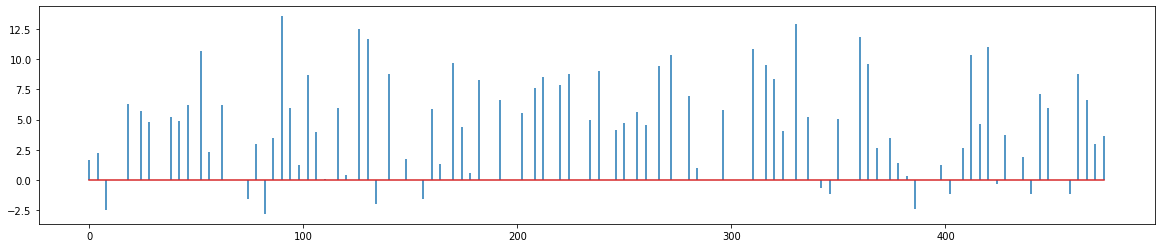

In [72]:
plt.figure(figsize=(20, 4))
plt.stem(df_events[0]['onset'], df_events[0]['U_risky'], markerfmt=' ')

In [73]:
# obtain the signal of interest by convolution
signals = []
for i in range(len(df_events)):
    signal, _ = compute_regressor(exp_condition, 'canonical', frametimes, con_id='main')
    signals.append(signal)

(481, 1)


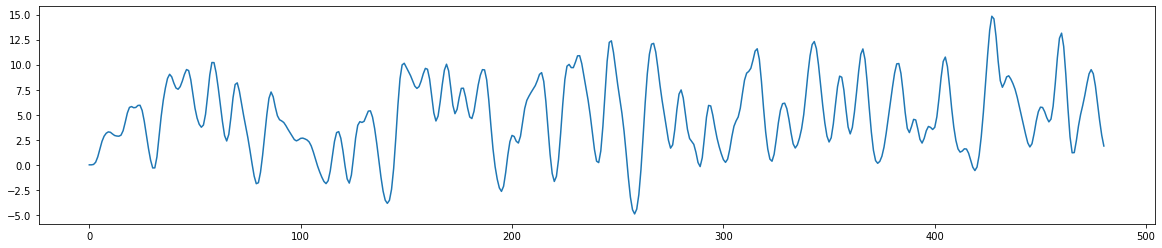

In [74]:
plt.figure(figsize=(20, 4))
print(signals[0].shape)
plt.plot(signals[0])

In [136]:
X = []
for i in range(len(signals)):
    x = signals[i][[int(fmri_info['tr'] * t) for t in range(fmri_info['t'])]]
    X.append(x)
X = np.array(X)
print(X.shape)

(3, 240, 1)


In [142]:
masker = NiftiMasker(mask_img=mask, standardize=True)
fmri_masked = [masker.fit_transform(image_sample) for image_sample in tqdm(image_samples)]

100%|██████████| 3/3 [02:22<00:00, 47.43s/it]


In [143]:
coefs_ = []
for i in tqdm(range(len(fmri_masked))):
    coef_ = []
    for Y in fmri_masked[i].reshape(-1, fmri_masked[i].shape[0]):
        reg = LinearRegression().fit(X[i], Y)
        coef_.append(float(reg.coef_))
    coefs_.append(coef_)
coefs_ = np.array(coefs_)

100%|██████████| 3/3 [02:32<00:00, 50.93s/it]


In [156]:
pos_coef = np.mean(coefs_, axis=0)
coef_img = masker.inverse_transform(pos_coef)
print(coef_img)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (91, 109, 91)
affine: 
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3  91 109  91   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [-1.  2.  2.  2.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code     

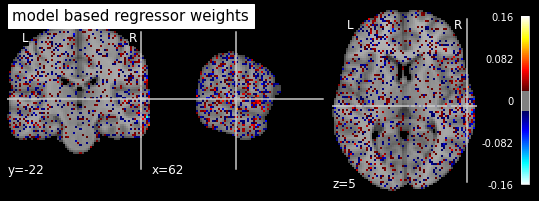

In [162]:
plot_stat_map(coef_img, bg_img=template,
              threshold=0.02,
              title='model based regressor weights')

show()